**URL:**

http://www.denel.co.za/press

In [1]:
#libraries
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pandas as pd,requests,bs4,re,time,io,pytesseract,easyocr,random,textstat,urllib.request
from pdfminer.high_level import extract_text
from PIL import Image
from pathlib import Path
from pdf2image import convert_from_path
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from goose3 import Goose
from datetime import datetime
from bs4 import BeautifulSoup
from selenium import webdriver
from tqdm.auto import tqdm

reader = easyocr.Reader(['en'])

import warnings
warnings.filterwarnings("ignore")

%autosave 1

Autosaving every 1 seconds


In [2]:
#driver for operation
from webdriver_manager.firefox import GeckoDriverManager
driver = webdriver.Firefox(executable_path=GeckoDriverManager().install())



====== WebDriver manager ======
Current firefox version is 102.0
Get LATEST geckodriver version for 102.0 firefox
Getting latest mozilla release info for v0.31.0
Trying to download new driver from https://github.com/mozilla/geckodriver/releases/download/v0.31.0/geckodriver-v0.31.0-win64.zip
Driver has been saved in cache [C:\Users\AKSHAY SATPUTE\.wdm\drivers\geckodriver\win64\v0.31.0]


In [3]:
#site name ,domain , site link
SITE_NAME='Denel'

DOMAIN = "http://www.denel.co.za"

SITE_LINK = "http://www.denel.co.za/press"

In [48]:
#functions
def remove_esc_chars(string):
    review = re.sub('''[^a-zA-Z0-9!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~°]''', ' ',string)
    review = review.split()
    review = ' '.join(review)
    return review

def get_text_thumb(link): 
    try:
        driver.get(link)
        thumb = "http://www.denel.co.za/images/logo.png"
        ps = driver.find_element(By.XPATH,'''/html/body/div[3]/table/tbody/tr/td/table''').text.strip()
        text = remove_esc_chars(ps).strip()
    except:
        thumb = "http://www.denel.co.za/images/logo.png"
        g = Goose()
        article_extract = g.extract(url=link)
        article = remove_esc_chars(article_extract.cleaned_text)
        meta_data = remove_esc_chars(article_extract.meta_description)
        whole_data = meta_data+article
        text = whole_data.strip()

        if textstat.lexicon_count(text, removepunct=True) < 5:
            try:
                response = requests.get(link)
                text = remove_esc_chars(extract_text(io.BytesIO(response.content)))

                if textstat.lexicon_count(text, removepunct=True) < 5:
                    texts = ""
                    r = requests.get(link)
                    filename = Path('temp.pdf')
                    filename.write_bytes(r.content)

                    pages = convert_from_path('temp.pdf', 500)
                    for x in pages:
                        x.save("temp.jpg")
                        output = reader.readtext("temp.jpg")
                        for o in output:
                            texts += o[1]

                    text = remove_esc_chars(texts)

                    if textstat.lexicon_count(text, removepunct=True) < 5:
                        texts = ""
                        soup = parse_webpage_bs(link)
                        if soup!= None:
                            ps = soup.findAll('p')
                            for p in ps:
                                texts+= p.text

                        text = remove_esc_chars(texts)
            except:
                text = ""
    
    return text , thumb

In [70]:
#get data
article_list = []

# get url 
url = f"http://www.denel.co.za/press"
driver.get(url)

#elements
elements = driver.find_elements(By.XPATH,'''/html/body/div[4]/div/table/tbody/tr[1]/td/table/tbody/tr/td/div''')

#accept cookies
try: 
    driver.find_element(By.XPATH,f'''/html/body/div[7]/div/div[2]/a''').click()
except:
    pass

#creating empty lists to append data 
published_dates,titles,texts,links,thumbnails,authors = [],[],[],[],[],[]

for e in tqdm(range(1,len(elements[:10])+1),desc = "Getting primary data"):
    try:
        published_date = driver.find_element(By.XPATH,f'''/html/body/div[4]/div/table/tbody/tr[1]/td/table/tbody/tr/td/div[{e}]/p[1]''').text.strip()
        title = driver.find_element(By.XPATH,f'''/html/body/div[4]/div/table/tbody/tr[1]/td/table/tbody/tr/td/div[{e}]/p[2]''').text.strip()
        link = driver.find_element(By.XPATH,f'''/html/body/div[4]/div/table/tbody/tr[1]/td/table/tbody/tr/td/div[{e}]/a''').get_attribute("href")
        author = SITE_NAME    
        
        published_dates.append(published_date)
        titles.append(title)
        links.append(link)
        authors.append(author)        

    except:
        pass
    
for link in tqdm(links,desc="Getting articles"):
    text,thumbnail = get_text_thumb(link)
    texts.append(text)
    thumbnails.append(thumbnail)
    
#zippig all the data togather 
zipped = list(zip(published_dates,titles,texts,links,thumbnails,authors))

#unwinding and appending to the main list
for published_date,title,text,link,thumbnail,author in zipped:
    article = (published_date.strip(),title.strip(),text.strip(),link.strip(),thumbnail.strip(),author.strip())
    article_list.append(article)
    print(published_date,title)

Getting primary data:   0%|          | 0/10 [00:00<?, ?it/s]

Getting articles:   0%|          | 0/10 [00:00<?, ?it/s]

28 June 2022 DENEL MEDICAL BENEFIT TRUST UPDATE
3 March 2022 Denel Medical Aid Subsidy Alternative Offer: Announcement
24 November 2021 Denel Medical Benefit Trust (DMBT) Update
9 November 2021 Denel Medical Benefit Trust (DMBT) Announcement
11 August 2021 Far-Reaching Steps To Ensure Denel's Sustainability
22 February 2021 Denel Appoints Mr William Hlakoane As Interim Group Chief Executive
17 August 2020 Denel Board Appoints Mr Talib Sadik as Interim Group Chief Executive
27 May 2020 LOCAL VENTILATOR PROJECTS ARE REACHING CRITICAL STAGES
25 April 2020 DENEL EMPLOYEES RETURN SAFELY FROM SPAIN
9 April 2020 MESSAGE BY PRESIDENT CYRIL RAMAPHOSA ON COVID-19 PANDEMIC


In [71]:
#temp df
temp_df = pd.DataFrame(article_list,columns=['date','title','article','url','thumbnail','author'])
temp_df.head()

,date,title,article,url,thumbnail,author
0,28 June 2022,DENEL MEDICAL BENEFIT TRUST UPDATE,Dear Beneficiary YOUR MEDICAL AID SUBSIDY As y...,http://www.denel.co.za/press-article/DENEL-MED...,http://www.denel.co.za/images/logo.png,Denel
1,3 March 2022,Denel Medical Aid Subsidy Alternative Offer: A...,Denel SOC Limited is pleased to announce that:...,http://www.denel.co.za/press-article/Denel-Med...,http://www.denel.co.za/images/logo.png,Denel
2,24 November 2021,Denel Medical Benefit Trust (DMBT) Update,Your medical aid subsidy offer letter from DEN...,http://www.denel.co.za/press-article/Denel-Med...,http://www.denel.co.za/images/logo.png,Denel
3,9 November 2021,Denel Medical Benefit Trust (DMBT) Announcement,Denel SOC Limited is pleased to announce that:...,http://www.denel.co.za/press-article/Denel-Med...,http://www.denel.co.za/images/logo.png,Denel
4,11 August 2021,Far-Reaching Steps To Ensure Denel's Sustainab...,A streamlined and refocused Denel will be able...,http://www.denel.co.za/press-article/Far-Reach...,http://www.denel.co.za/images/logo.png,Denel


11 August 2021 Far-Reaching Steps To Ensure Denel's Sustainability

Denel http://www.denel.co.za/press-article/Far-Reaching-Steps-To-Ensure-Denels-Sustainability/235


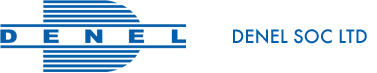


A streamlined and refocused Denel will be able to be a sustainable business and return to profitability within the next five years. This will be done through a comprehensive restructuring of the defence technology company. We are determined to turn Denel around and repurpose it while retaining the core capabilities required to meet South Africa s strategic security requirements, says William Hlakoane, the company s interim Group Chief Executive. Furthermore, we are encouraged by the unwavering support that we have been receiving from our shareholder, the Department of Public Enterprises. This is underlined by its acknowledgement that there is a need to assist Denel with regards to its financial situation. Thus, I am positive that the discussions with other government departments that have keen interest in Denel s survival such as the Department of Defence and the National Treasury will soon bear positive results . For our part as executive management and the Board, we have put togethe

In [75]:
#see data
def see_data(iloc_no=random.randint(0,len(temp_df))-1):
    print(temp_df.iloc[iloc_no]['date'],temp_df.iloc[iloc_no]['title'])
    print(f"\n{temp_df.iloc[iloc_no]['author']} {temp_df.iloc[iloc_no]['url']}")
    urllib.request.urlretrieve(temp_df.iloc[iloc_no]['thumbnail'], "temp.jpg")
    display(Image.open("temp.jpg"))
    print(f"\n{temp_df.iloc[iloc_no]['article']}")

see_data()

In [76]:
#to csv
temp_df.to_csv(f'{SITE_NAME} news.csv',index = False)

#to json
temp_df.to_json(f'{SITE_NAME} news.json')

In [77]:
#to get rid of unwanteed trash created by the model use 
def remove_trash():
    try:
        try:
            os.remove("temp.pdf")
        except:
            pass
        os.remove("temp.jpg")
        print("Trash removed successfully")
    except:
        print("No trash found")

remove_trash()

Trash removed successfully
